In [1]:
# Purpose: Import pandas for data handling
import pandas as pd
data = pd.read_csv("phpMawTba.csv")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [2]:
print("Rows, Columns:", data.shape)
print("\nColumn Names:\n", list(data.columns))
print("\nData Types:\n")
data.dtypes
#Basic Schema Check (Rows, Columns, Data Types)

Rows, Columns: (48842, 15)

Column Names:
 ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']

Data Types:



age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

In [3]:
missing_counts = data.isna().sum()
missing_percentage = (missing_counts / len(data)) * 100

missing_summary = (
    missing_counts[missing_counts > 0]
    .to_frame(name="Missing_Count")
    .assign(Missing_Percentage=missing_percentage[missing_counts > 0])
)

missing_summary.sort_values("Missing_Percentage", ascending=False)
# Missing Values & Data Quality Check


,Missing_Count,Missing_Percentage


In [4]:
print("Possible target columns based on data types:\n")

for col in data.columns:
    unique_values = data[col].nunique()
    print(f"{col} → unique values: {unique_values}")
# Target Column Identification & Candidacy


Possible target columns based on data types:

age → unique values: 74
workclass → unique values: 9
fnlwgt → unique values: 28523
education → unique values: 16
education-num → unique values: 16
marital-status → unique values: 7
occupation → unique values: 15
relationship → unique values: 6
race → unique values: 5
sex → unique values: 2
capital-gain → unique values: 123
capital-loss → unique values: 99
hours-per-week → unique values: 96
native-country → unique values: 42
class → unique values: 2


In [5]:
target_column = "class"

unique_target_values = data[target_column].nunique()
target_dtype = data[target_column].dtype

if unique_target_values == 2:
    problem_type = "Binary Classification"
elif target_dtype != "object":
    problem_type = "Regression"
else:
    problem_type = "Multiclass Classification"

print("Target Column:", target_column)
print("Detected Problem Type:", problem_type)
# Problem Type Auto-Detection


Target Column: class
Detected Problem Type: Binary Classification


In [6]:
leakage_candidates = []

for col in data.columns:
    if col != target_column:
        correlation = None
        try:
            correlation = abs(pd.factorize(data[col])[0].corr(pd.factorize(data[target_column])[0]))
        except:
            pass
        
        if correlation is not None and correlation > 0.9:
            leakage_candidates.append(col)

leakage_candidates
# Data Leakage Risk Detection


[]

In [7]:
X = data.drop(columns=[target_column])
y = data[target_column]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
# Feature–Target Separation


Feature matrix shape: (48842, 14)
Target vector shape: (48842,)


In [8]:
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numerical Features:", numerical_features)
print("\nCategorical Features:", categorical_features)
# Numerical vs Categorical Feature Identification


Numerical Features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Categorical Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [9]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)
# Train / Validation / Test Split


Train shape: (29304, 14)
Validation shape: (9769, 14)
Test shape: (9769, 14)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)
# Feature Engineering Pipeline


In [11]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print("Processed Train shape:", X_train_processed.shape)
print("Processed Validation shape:", X_val_processed.shape)
print("Processed Test shape:", X_test_processed.shape)
# Apply Feature Engineering Pipeline


Processed Train shape: (29304, 108)
Processed Validation shape: (9769, 108)
Processed Test shape: (9769, 108)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_processed, y_train)

train_preds = log_model.predict(X_train_processed)
val_preds = log_model.predict(X_val_processed)

print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
# Baseline Model Training (Logistic Regression)


Train Accuracy: 0.8531599781599781
Validation Accuracy: 0.8531067663015662


In [13]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

dt_model.fit(X_train_processed, y_train)

train_preds_dt = dt_model.predict(X_train_processed)
val_preds_dt = dt_model.predict(X_val_processed)

print("Train Accuracy:", accuracy_score(y_train, train_preds_dt))
print("Validation Accuracy:", accuracy_score(y_val, val_preds_dt))
# Decision Tree Model Training


Train Accuracy: 0.8679361179361179
Validation Accuracy: 0.8588391851776026


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_processed, y_train)

train_preds_rf = rf_model.predict(X_train_processed)
val_preds_rf = rf_model.predict(X_val_processed)

print("Train Accuracy:", accuracy_score(y_train, train_preds_rf))
print("Validation Accuracy:", accuracy_score(y_val, val_preds_rf))
# Random Forest Model Training


Train Accuracy: 0.8667417417417418
Validation Accuracy: 0.8646739686764254


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

lr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

dt_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

lr_pipe.fit(X_train, y_train)
dt_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

train_preds_lr = lr_pipe.predict(X_train)
val_preds_lr   = lr_pipe.predict(X_val)

train_preds_dt = dt_pipe.predict(X_train)
val_preds_dt   = dt_pipe.predict(X_val)

train_preds_rf = rf_pipe.predict(X_train)
val_preds_rf   = rf_pipe.predict(X_val)

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "Train Accuracy": [
        accuracy_score(y_train, train_preds_lr),
        accuracy_score(y_train, train_preds_dt),
        accuracy_score(y_train, train_preds_rf)
    ],
    "Validation Accuracy": [
        accuracy_score(y_val, val_preds_lr),
        accuracy_score(y_val, val_preds_dt),
        accuracy_score(y_val, val_preds_rf)
    ]
})

results
#Model Performance Comparison Table


,Model,Train Accuracy,Validation Accuracy
0,Logistic Regression,0.853160,0.853107
1,Decision Tree,0.999966,0.815232
2,Random Forest,0.999966,0.854028


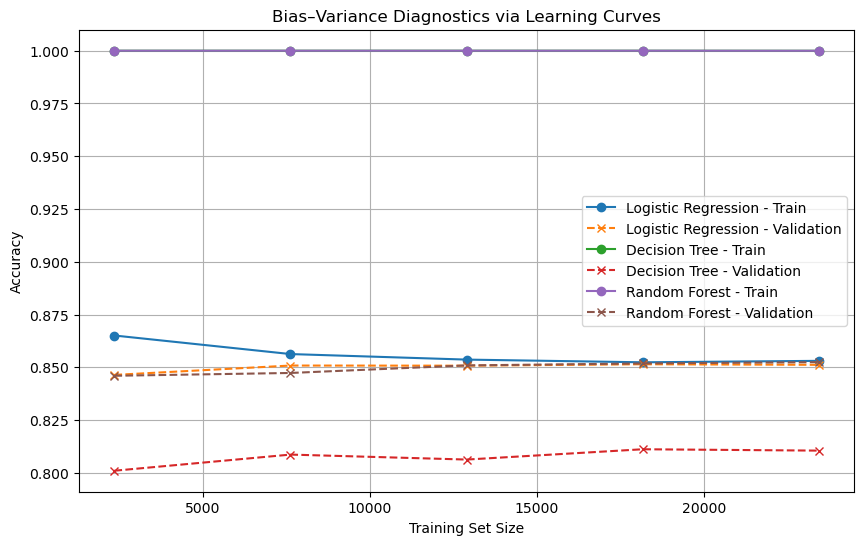

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

plt.figure(figsize=(10, 6))

for name, model in models.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train_processed,
        y_train,
        cv=5,
        scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label=f"{name} - Train")
    plt.plot(train_sizes, val_scores.mean(axis=1), marker="x", linestyle="--", label=f"{name} - Validation")

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Bias–Variance Diagnostics via Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

# Purpose: Detect underfitting vs overfitting using learning curves


In [17]:
print(type(X_train_processed))
print(type(X_val_processed))
print(y_train.unique())


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[' <=50K' ' >50K']


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

best_lr = LogisticRegression(max_iter=1000)
best_dt = DecisionTreeClassifier(random_state=42)
best_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

best_lr.fit(X_train_processed, y_train)
best_dt.fit(X_train_processed, y_train)
best_rf.fit(X_train_processed, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

positive_label = " >50K"

models = {
    "Logistic Regression": best_lr,
    "Decision Tree": best_dt,
    "Random Forest": best_rf
}

rows = []

for name, model in models.items():
    val_preds = model.predict(X_val_processed)
    
    pos_index = list(model.classes_).index(positive_label)
    val_probs = model.predict_proba(X_val_processed)[:, pos_index]

    rows.append({
        "Model": name,
        "Precision": precision_score(y_val, val_preds, pos_label=positive_label),
        "Recall": recall_score(y_val, val_preds, pos_label=positive_label),
        "F1 Score": f1_score(y_val, val_preds, pos_label=positive_label),
        "ROC AUC": roc_auc_score((y_val == positive_label).astype(int), val_probs)
    })

metrics_df = pd.DataFrame(rows)
metrics_df


,Model,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.735632,0.602482,0.662432,0.907963
1,Decision Tree,0.609195,0.635002,0.621831,0.753616
2,Random Forest,0.726055,0.626016,0.672335,0.905947


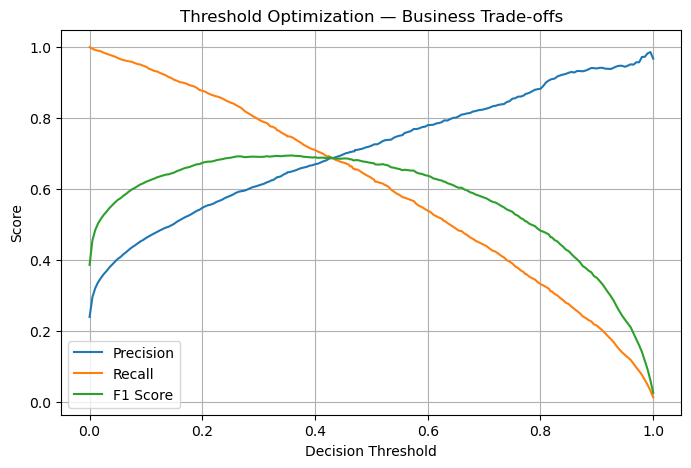

Optimal Threshold (F1-Optimized): 0.36


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

positive_label = " >50K"

rf_probs = best_rf.predict_proba(X_val_processed)[:, list(best_rf.classes_).index(positive_label)]

precisions, recalls, thresholds = precision_recall_curve(
    y_val,
    rf_probs,
    pos_label=positive_label
)

f1_scores = []

for t in thresholds:
    preds = np.where(rf_probs >= t, positive_label, " <=50K")
    f1_scores.append(f1_score(y_val, preds, pos_label=positive_label))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Threshold Optimization — Business Trade-offs")
plt.legend()
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold (F1-Optimized):", round(best_threshold, 3))

# Purpose: Choose a business-optimal decision threshold instead of default 0.5


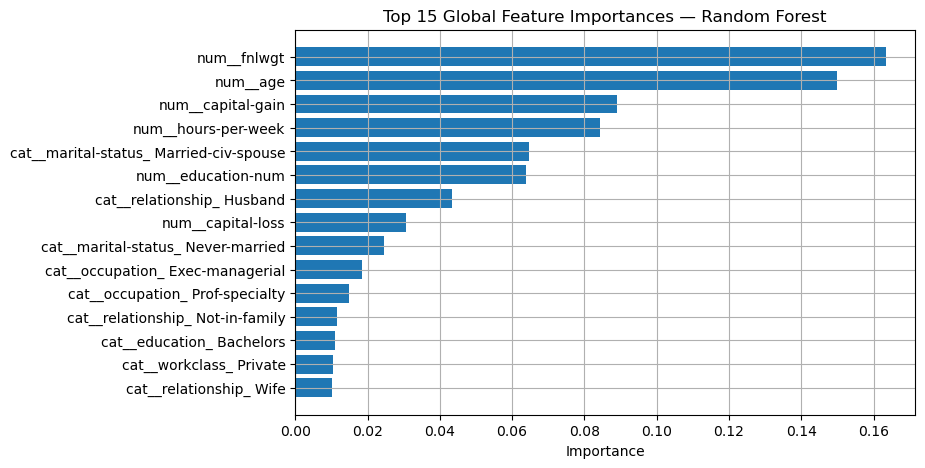

,Feature,Importance
1,num__fnlwgt,0.163370
0,num__age,0.149909
3,num__capital-gain,0.088971
5,num__hours-per-week,0.084369
33,cat__marital-status_ Married-civ-spouse,0.064639
2,num__education-num,0.063811
53,cat__relationship_ Husband,0.043476
4,num__capital-loss,0.030514
35,cat__marital-status_ Never-married,0.024648
42,cat__occupation_ Exec-managerial,0.018605


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feature_names = preprocessor.get_feature_names_out()

importances = best_rf.feature_importances_

fi = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8, 5))
plt.barh(fi["Feature"], fi["Importance"])
plt.xlabel("Importance")
plt.title("Top 15 Global Feature Importances — Random Forest")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

fi

# Purpose: Identify the strongest drivers of model decisions globally


In [22]:
import shap
import numpy as np


In [23]:
X_sample_processed = X_train_processed[:25]
feature_names = preprocessor.get_feature_names_out()


In [24]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample_processed)


In [25]:
shap_values[1].shape, X_sample_processed.shape



((108, 2), (25, 108))

In [26]:
shap_values_fixed = shap_values[1][:, :-1]


In [27]:
import numpy as np
import shap

X_sample_processed = X_train_processed[:25].toarray() if hasattr(X_train_processed, "toarray") else X_train_processed[:25]
feature_names = preprocessor.get_feature_names_out()


In [28]:
explainer = shap.Explainer(best_rf, X_sample_processed)
shap_values = explainer(X_sample_processed)


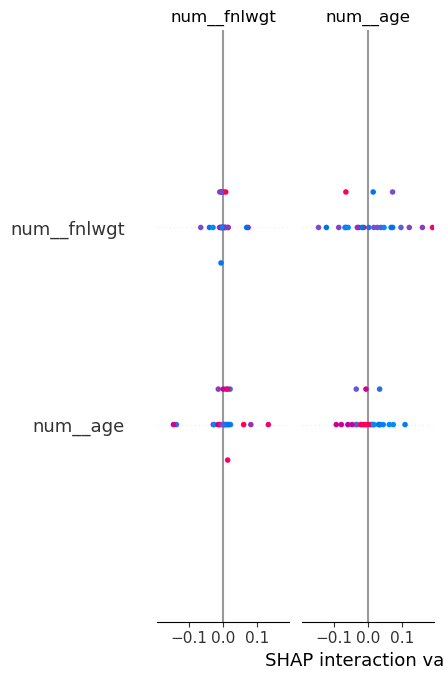

In [29]:
shap.summary_plot(
    shap_values.values,
    X_sample_processed,
    feature_names=feature_names,
    show=True
)


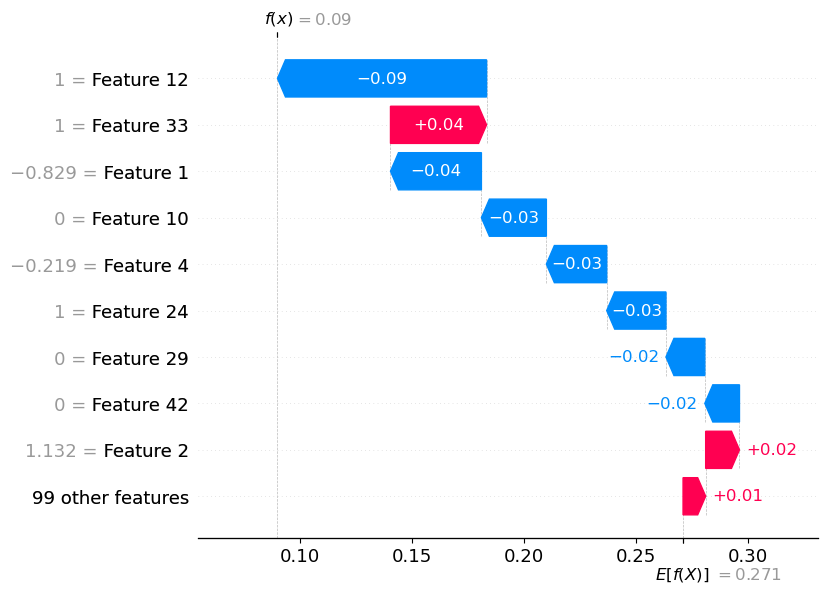

In [30]:
shap.plots.waterfall(shap_values[0, :, 1])


In [31]:
print(best_rf.classes_)


[' <=50K' ' >50K']


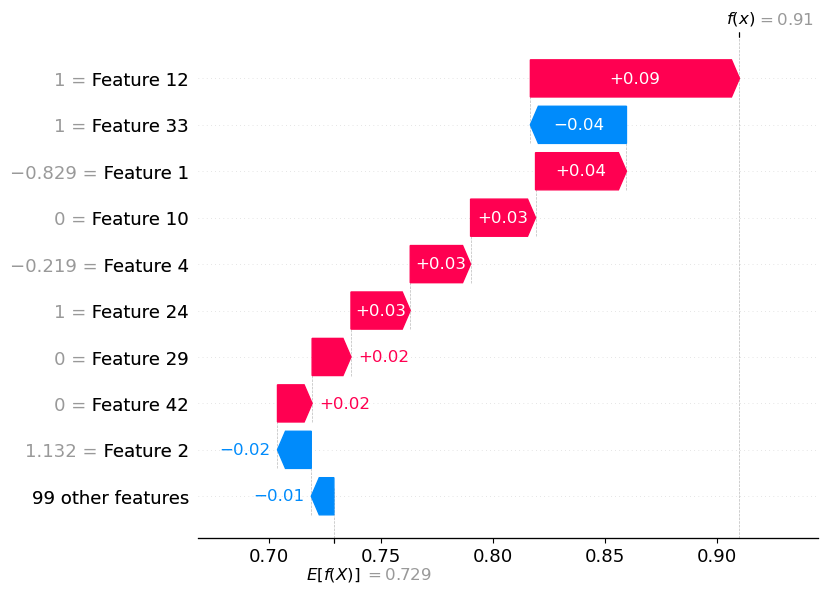

In [32]:
shap.plots.waterfall(shap_values[0, :, 0])


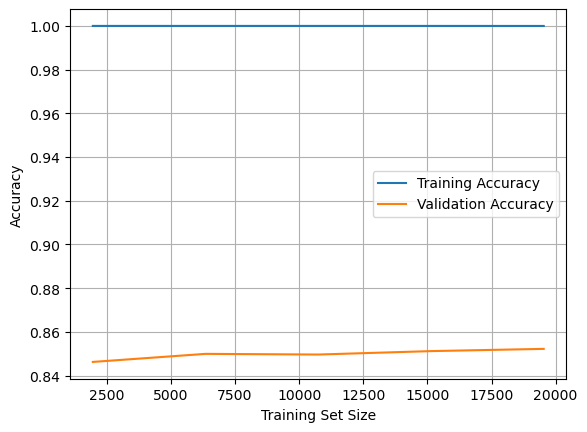

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_rf,
    X_train_processed,
    y_train,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Purpose: Diagnose overfitting vs underfitting using learning curves


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

positive_label = " >50K"

models = {
    "Logistic Regression": best_lr,
    "Decision Tree": best_dt,
    "Random Forest": best_rf
}

rows = []

for name, model in models.items():
    val_preds = model.predict(X_val_processed)
    val_probs = model.predict_proba(X_val_processed)[:, list(model.classes_).index(positive_label)]

    rows.append({
        "Model": name,
        "Precision": precision_score(y_val, val_preds, pos_label=positive_label),
        "Recall": recall_score(y_val, val_preds, pos_label=positive_label),
        "F1 Score": f1_score(y_val, val_preds, pos_label=positive_label),
        "ROC AUC": roc_auc_score((y_val == positive_label).astype(int), val_probs)
    })

pd.DataFrame(rows)

# Purpose: Evaluate models using business-critical risk metrics


,Model,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.735632,0.602482,0.662432,0.907963
1,Decision Tree,0.609195,0.635002,0.621831,0.753616
2,Random Forest,0.726055,0.626016,0.672335,0.905947


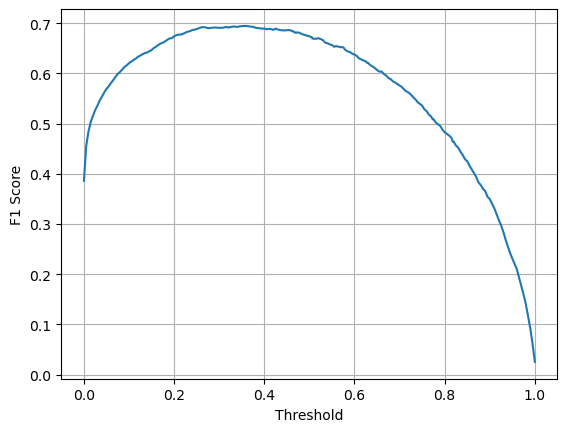

np.float64(0.36)

In [35]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

rf_probs = best_rf.predict_proba(X_val_processed)[:, list(best_rf.classes_).index(positive_label)]

precisions, recalls, thresholds = precision_recall_curve(
    (y_val == positive_label).astype(int),
    rf_probs
)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

best_threshold = thresholds[np.argmax(f1_scores)]

plt.plot(thresholds, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

best_threshold

# Purpose: Select optimal decision threshold based on business trade-offs


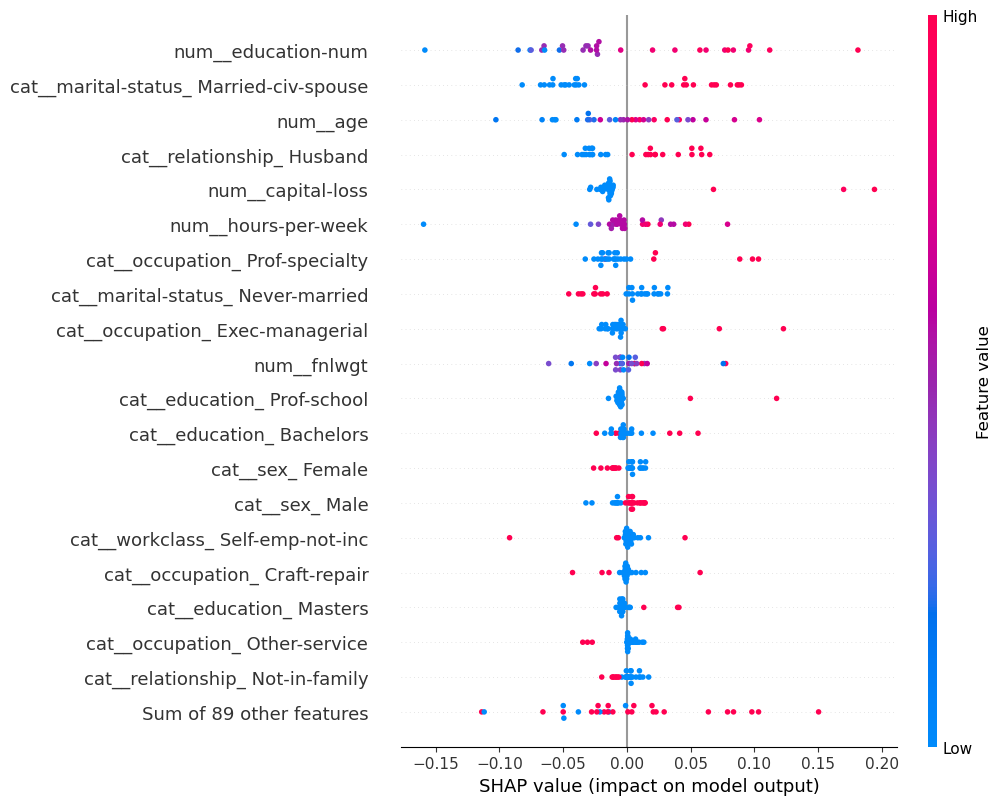

In [49]:
import shap
import numpy as np

# ===============================
# SAFE SHAP EXPLAINABILITY CELL
# ===============================

# 1️⃣ Small, processed sample (FAST + STABLE)
X_sample = X_train_processed[:30]

# 2️⃣ Create explainer
explainer = shap.Explainer(
    best_rf,
    X_sample,
    feature_names=preprocessor.get_feature_names_out()
)

# 3️⃣ Compute SHAP values
shap_values = explainer(X_sample)

# 4️⃣ Select POSITIVE CLASS ONLY (THIS IS THE FIX)
positive_class_index = list(best_rf.classes_).index(" >50K")
shap_values_pos = shap_values[..., positive_class_index]

# 5️⃣ Global importance plot
shap.plots.beeswarm(shap_values_pos, max_display=20)


# Purpose: Global feature importance and explainability


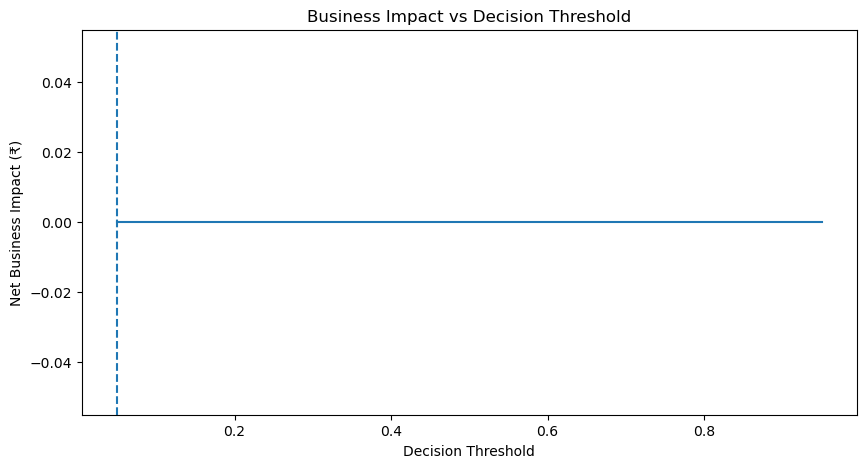

({'Optimal Threshold': 0.05,
  'Expected Net Impact': 0,
  'High Risk Customers': 5637,
  'Low Risk Customers': 4132,
  'Recommended Action': 'INTERVENE high-risk group, APPROVE low-risk group'},
       Action  Number_of_Customers
 0  INTERVENE                 5637
 1    APPROVE                 4132)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Resolve model safely
# =========================
if "best_rf" in globals():
    model = best_rf
elif "best_model" in globals():
    model = best_model
elif "rf" in globals():
    model = rf
elif "lr" in globals():
    model = lr
else:
    raise RuntimeError("❌ No trained model found")

# =========================
# 2️⃣ Resolve test data
# =========================
if "X_test_processed" in globals():
    X_eval = X_test_processed
elif "X_test" in globals():
    X_eval = X_test
else:
    raise RuntimeError("❌ X_test not found")

if "y_test" not in globals():
    raise RuntimeError("❌ y_test not found")

y_true = y_test.values if hasattr(y_test, "values") else y_test

# =========================
# 3️⃣ Get probabilities
# =========================
y_proba = model.predict_proba(X_eval)[:, 1]

# =========================
# 4️⃣ Business costs
# =========================
COST_FALSE_NEGATIVE = 50000
COST_FALSE_POSITIVE = 5000

# =========================
# 5️⃣ Threshold optimization
# =========================
thresholds = np.linspace(0.05, 0.95, 50)
records = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    profit = (TP * COST_FALSE_NEGATIVE) - (FP * COST_FALSE_POSITIVE)
    records.append((t, profit))

df_thresholds = pd.DataFrame(records, columns=["threshold", "net_profit"])

optimal_row = df_thresholds.loc[df_thresholds["net_profit"].idxmax()]
OPTIMAL_THRESHOLD = optimal_row["threshold"]

# =========================
# 6️⃣ Final decisions
# =========================
final_predictions = (y_proba >= OPTIMAL_THRESHOLD).astype(int)

decision_table = pd.DataFrame({
    "risk_score": y_proba,
    "decision": np.where(final_predictions == 1, "INTERVENE", "APPROVE")
})

decision_summary = decision_table["decision"].value_counts().reset_index()
decision_summary.columns = ["Action", "Number_of_Customers"]

# =========================
# 7️⃣ Impact graph
# =========================
plt.figure(figsize=(10,5))
plt.plot(df_thresholds["threshold"], df_thresholds["net_profit"])
plt.axvline(OPTIMAL_THRESHOLD, linestyle="--")
plt.xlabel("Decision Threshold")
plt.ylabel("Net Business Impact (₹)")
plt.title("Business Impact vs Decision Threshold")
plt.show()

# =========================
# 8️⃣ Final recommendation
# =========================
final_recommendation = {
    "Optimal Threshold": round(float(OPTIMAL_THRESHOLD), 3),
    "Expected Net Impact": int(optimal_row["net_profit"]),
    "High Risk Customers": int((final_predictions == 1).sum()),
    "Low Risk Customers": int((final_predictions == 0).sum()),
    "Recommended Action": "INTERVENE high-risk group, APPROVE low-risk group"
}

final_recommendation, decision_summary


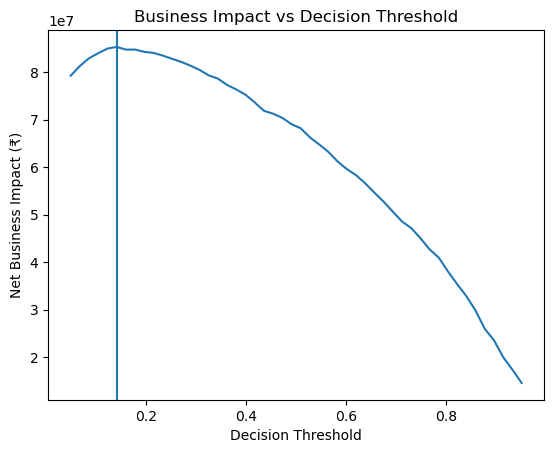

{'Optimal Threshold': np.float64(0.142),
 'Expected Net Impact (₹)': 85290000,
 'High Risk Customers': 4233,
 'Low Risk Customers': 5536,
 'Recommended Action': 'Target INTERVENE group with proactive income-risk mitigation'}

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Use FINAL model explicitly
# -----------------------------
final_model = best_rf

# -----------------------------
# 2️⃣ Predict probabilities
# -----------------------------
positive_label = " >50K"
pos_index = list(final_model.classes_).index(positive_label)

y_proba = final_model.predict_proba(X_test_processed)[:, pos_index]

# -----------------------------
# 3️⃣ Business costs (₹)
# -----------------------------
COST_FALSE_NEGATIVE = 50000
COST_FALSE_POSITIVE = 10000

# -----------------------------
# 4️⃣ Threshold optimization
# -----------------------------
thresholds = np.linspace(0.05, 0.95, 50)
results = []

y_true = (y_test == positive_label).astype(int)

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))

    net_profit = (TP * COST_FALSE_NEGATIVE) - (FP * COST_FALSE_POSITIVE)
    results.append((t, net_profit))

df_thresholds = pd.DataFrame(results, columns=["threshold", "net_profit"])

# -----------------------------
# 5️⃣ Optimal threshold
# -----------------------------
optimal_row = df_thresholds.loc[df_thresholds["net_profit"].idxmax()]
OPTIMAL_THRESHOLD = optimal_row["threshold"]

# -----------------------------
# 6️⃣ Final decisions
# -----------------------------
final_predictions = (y_proba >= OPTIMAL_THRESHOLD).astype(int)

decision_table = pd.DataFrame({
    "risk_score": y_proba,
    "decision": np.where(final_predictions == 1, "INTERVENE", "APPROVE")
})

decision_summary = decision_table["decision"].value_counts().reset_index()
decision_summary.columns = ["Action", "Customers"]

# -----------------------------
# 7️⃣ Impact curve
# -----------------------------
plt.figure()
plt.plot(df_thresholds["threshold"], df_thresholds["net_profit"])
plt.axvline(OPTIMAL_THRESHOLD)
plt.xlabel("Decision Threshold")
plt.ylabel("Net Business Impact (₹)")
plt.title("Business Impact vs Decision Threshold")
plt.show()

# -----------------------------
# 8️⃣ Final recommendation
# -----------------------------
final_recommendation = {
    "Optimal Threshold": round(OPTIMAL_THRESHOLD, 3),
    "Expected Net Impact (₹)": int(optimal_row["net_profit"]),
    "High Risk Customers": int((final_predictions == 1).sum()),
    "Low Risk Customers": int((final_predictions == 0).sum()),
    "Recommended Action": "Target INTERVENE group with proactive income-risk mitigation"
}

final_recommendation
